# Koopman kernel models for TC Tracks

## Tropical cyclone dataset (1970 - 2020)

In this notebook we focus on the Nynstroem kernel and analyze the training results for a larger dataset and various choices of hyperparameter.

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from kooplearn.models import Kernel, NystroemKernel
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    TCTracks_from_TensorContextDataset,
)
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)
from klearn_tcyclone.models_utils import predict_time_series
from klearn_tcyclone.performance_benchmark import timer

from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product

In [2]:
def load_model_results(flag_params: dict, path_training_results: str, train_stops, load_keys: str | list[str] | None=None):
    # combine with from klearn_tcyclone.data_utils import load_model_results, load_model

    if load_keys == "all":
        load_keys = ["model", "scaler", "eval_rmse", "train_stop", "fit_time"]
    elif load_keys is None:
        load_keys = ["eval_rmse", "train_stop", "fit_time"]
    
    import_dir = os.path.join(
        path_training_results,
        "{}_yrange{}".format(
            flag_params["dataset"],
            "".join(map(str,flag_params["year_range"])),
        ),
        flag_params["model"],
    )

    model_name = "seed{}_kklnscale{}_kkrank{}_kkrdrank{}_kktkreg{}_kkncntr{}_kkntstops{}_kkcntlength{}".format(
        flag_params["seed"],
        flag_params["koopman_kernel_length_scale"],
        flag_params["koopman_kernel_rank"],
        flag_params["koopman_kernel_reduced_rank"],
        flag_params["tikhonov_reg"],
        flag_params["koopman_kernel_num_centers"],
        flag_params["koopman_kernel_num_train_stops"],
        flag_params["context_length"],
    )

    results_file_name = os.path.join(import_dir, model_name)
    file_list = glob.glob(os.path.join(import_dir, "*train_steps*.pth"))
    results = {}
    for stop in train_stops:
    # for file_name in file_list:
        res= torch.load(
            # file_name,
            results_file_name + f"_train_steps{stop}.pth"
        )
        # results[res["train_stop"]] = res
        # results[stop] = res
        results[stop] = {}
        for key in load_keys:
            results[stop][key] = res[key]
    # file_name_best = glob.glob(os.path.join(import_dir, "*best.pth"))[0]
    # results["best"] = torch.load(file_name_best)
    results["best"] = torch.load(results_file_name + f"_best.pth")

    return results

def load_model(flag_params: dict, path_training_results):
    # combine with from klearn_tcyclone.data_utils import load_model_results, load_model    
    
    import_dir = os.path.join(
        path_training_results,
        "{}_yrange{}".format(
            flag_params["dataset"],
            "".join(map(str,flag_params["year_range"])),
        ),
        flag_params["model"],
    )

    model_name = "seed{}_kklnscale{}_kkrank{}_kkrdrank{}_kktkreg{}_kkncntr{}_kkntstops{}_kkcntlength{}".format(
        flag_params["seed"],
        flag_params["koopman_kernel_length_scale"],
        flag_params["koopman_kernel_rank"],
        flag_params["koopman_kernel_reduced_rank"],
        flag_params["tikhonov_reg"],
        flag_params["koopman_kernel_num_centers"],
        flag_params["koopman_kernel_num_train_stops"],
        flag_params["context_length"],
    )

    results_file_name = os.path.join(import_dir, model_name)

    model_dict = torch.load(
        results_file_name + f"_best_model.pth"
    )

    return model_dict

Set some specific parameters, such as the Koopman kernel model, and load default values for all other parameters.

## Analyze training results

In the following we will focus on the Nystroem_RRR kernel and compare test RMSE values for various hyperparameter configurations.

We consider the kernel length scale, the kernel rank and the number of centers of the Nystroem kernel.

The model training and test RMSE evaluation is done in `train_models/`. Below, the considered hyperparameter values are given, `train_stops` contains a list stopping points for the trainig, i.e. the number of training data points used for model training. 

In [3]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"
train_stops = [316, 480, 730, 1110, 1687, 2564, 3897, 5923, 9002, 13682]
koopman_kernel_length_scale=(0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0)
koopman_kernel_rank=(5, 25, 45)
koopman_kernel_num_centers=(100, 150, 200, 250, 300, 350)

We first import the model training results.

In [4]:
def load_model_results(flag_params: dict, path_training_results: str, train_stops, load_keys: str | list[str] | None=None):
    # combine with from klearn_tcyclone.data_utils import load_model_results, load_model

    if load_keys == "all":
        load_keys = ["model", "scaler", "eval_rmse", "train_stop", "fit_time"]
    elif load_keys is None:
        load_keys = ["eval_rmse", "train_stop", "fit_time"]
    
    import_dir = os.path.join(
        path_training_results,
        "{}_yrange{}".format(
            flag_params["dataset"],
            "".join(map(str,flag_params["year_range"])),
        ),
        flag_params["model"],
    )

    model_name = "seed{}_kklnscale{}_kkrank{}_kkrdrank{}_kktkreg{}_kkncntr{}_kkntstops{}_kkcntlength{}".format(
        flag_params["seed"],
        flag_params["koopman_kernel_length_scale"],
        flag_params["koopman_kernel_rank"],
        flag_params["koopman_kernel_reduced_rank"],
        flag_params["tikhonov_reg"],
        flag_params["koopman_kernel_num_centers"],
        flag_params["koopman_kernel_num_train_stops"],
        flag_params["context_length"],
    )

    results_file_name = os.path.join(import_dir, model_name)
    results = {}
    for stop in train_stops:
        res= torch.load(
            results_file_name + f"_train_steps{stop}_results.pth"
        )
        results[stop] = {}
        for key in load_keys:
            results[stop][key] = res[key]
    results["best"] = torch.load(results_file_name + f"_best_results.pth")

    return results

In [5]:
rmse_arr = np.zeros((len(train_stops), len(koopman_kernel_length_scale), len(koopman_kernel_rank), len(koopman_kernel_num_centers)))
for i, j, k in product(range(len(koopman_kernel_length_scale)), range(len(koopman_kernel_rank)), range(len(koopman_kernel_num_centers))):
    flag_params = {
        "koopman_kernel_num_train_stops": 10,
        "year_range": [1970, 2020],
        "model": model_str,
        "koopman_kernel_length_scale": koopman_kernel_length_scale[i],
        "koopman_kernel_rank": koopman_kernel_rank[j],
        "koopman_kernel_num_centers": koopman_kernel_num_centers[k],
    }
    flag_params = extend_by_default_flag_values(flag_params)
    res = load_model_results(flag_params, path_training_results, train_stops)    
    rmse_arr[:, i, j, k] = [res[stop]["eval_rmse"] for stop in train_stops]

C:\Users\Eric\AppData\Local\Temp\ipykernel_13680\3092810427.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res= torch.load(
C:\Users\Eric\AppData\Local\Temp\ipykernel_

In [6]:
# fig, ax = plt.subplots(1,3)
# fig.set_size_inches(12,3)

# stop_idx = -1

# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# im = ax[0].matshow(rmse_arr[stop_idx,:,0,:])
# fig.colorbar(im, cax=cax, orientation='vertical')

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# im = ax[1].matshow(rmse_arr[stop_idx,:,1,:])
# fig.colorbar(im, cax=cax, orientation='vertical')

# divider = make_axes_locatable(ax[2])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# im = ax[2].matshow(rmse_arr[stop_idx,:,2,:])
# fig.colorbar(im, cax=cax, orientation='vertical')



Below we fix the kernel length scale to the best performing value (see plot below as well) of `length_scale = 10`. The three panels show the three considered kernel rank values, the colors indicate different values for the number of centers, as specified in the legend.

We observe that the number of centers only has a marginal effect. Larger kernel ranks lead to smaller RMSE, but there is not a huge difference between `kernel_rank=25` and `kernel_rank = 45` for the considered dataset.

Text(0.5, 0.98, 'RMSE comparison for fixed kernel length scale = 10.0')

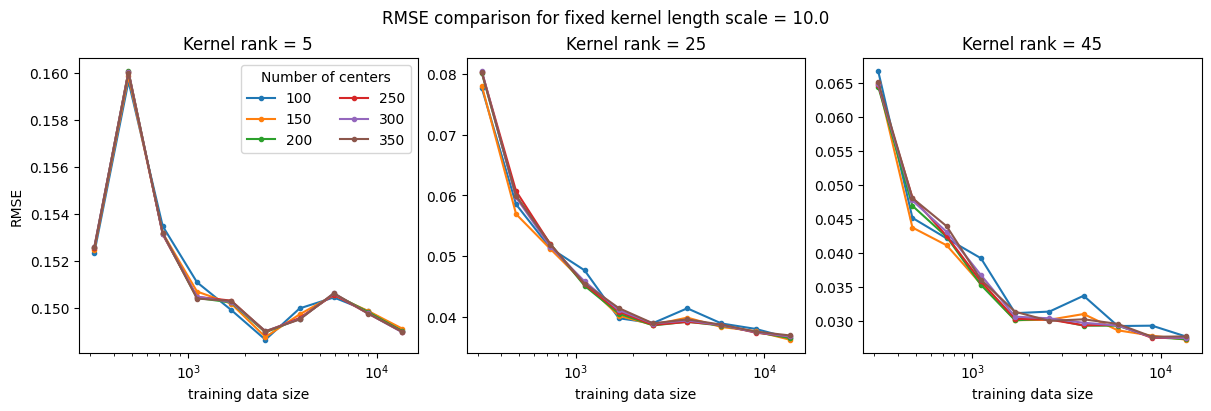

In [7]:
fig, ax = plt.subplots(1,3, layout="constrained")
fig.set_size_inches(12,4)


kk_ls_idx = 3

kk_krank_idx = 0
for kk_nc_idx in range(len(koopman_kernel_num_centers)):
    ax[0].plot(train_stops, rmse_arr[:, kk_ls_idx, kk_krank_idx, kk_nc_idx], label=f"{koopman_kernel_num_centers[kk_nc_idx]}", marker=".")
ax[0].set_xscale("log")
ax[0].legend(title="Number of centers", ncols=2)
ax[0].set_title(f"Kernel rank = {koopman_kernel_rank[kk_krank_idx]}")
ax[0].set_xlabel("training data size")
ax[0].set_ylabel("RMSE")

kk_krank_idx = 1
for kk_nc_idx in range(len(koopman_kernel_num_centers)):
    ax[1].plot(train_stops, rmse_arr[:, kk_ls_idx, kk_krank_idx, kk_nc_idx], label=f"{koopman_kernel_num_centers[kk_nc_idx]}", marker=".")
ax[1].set_xscale("log")
ax[1].set_title(f"Kernel rank = {koopman_kernel_rank[kk_krank_idx]}")
ax[1].set_xlabel("training data size")

kk_krank_idx = 2
for kk_nc_idx in range(len(koopman_kernel_num_centers)):
    ax[2].plot(train_stops, rmse_arr[:, kk_ls_idx, kk_krank_idx, kk_nc_idx], label=f"{koopman_kernel_num_centers[kk_nc_idx]}", marker=".")
ax[2].set_xscale("log")
ax[2].set_title(f"Kernel rank = {koopman_kernel_rank[kk_krank_idx]}")
ax[2].set_xlabel("training data size")

fig.suptitle(f"RMSE comparison for fixed kernel length scale = {koopman_kernel_length_scale[kk_ls_idx]}")

In the next plot we consider the influence of the length scale, for a fixed number of centers for the kernel of 500. The three panels again show the three considered kernel rank values, the colors indicate here different values for the kernel length scale, as specified in the legend.

The kernel length scale has a clear effect on the test RMSE. We observe best model performance for `length_scale = 10` for kernel rank 25 and 45. Interestingly, for a small kernel rank of 5, `length_scale = 50` performs best.

Text(0.5, 0.98, 'RMSE comparison for fixed number of centers = 500.0')

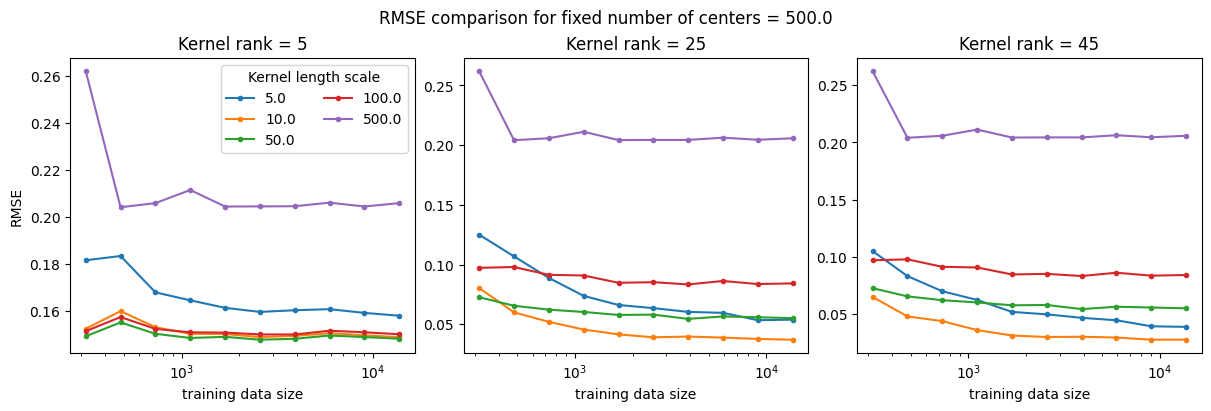

In [8]:
fig, ax = plt.subplots(1,3, layout="constrained")
fig.set_size_inches(12,4)


kk_ls_idx = 2
kk_nc_idx = 5

kk_krank_idx = 0
for kk_ls_idx in range(2, len(koopman_kernel_length_scale)):
    ax[0].plot(train_stops, rmse_arr[:, kk_ls_idx, kk_krank_idx, kk_nc_idx], label=f"{koopman_kernel_length_scale[kk_ls_idx]}", marker=".")
ax[0].set_xscale("log")
ax[0].legend(title="Kernel length scale", ncols=2)
ax[0].set_title(f"Kernel rank = {koopman_kernel_rank[kk_krank_idx]}")
ax[0].set_xlabel("training data size")
ax[0].set_ylabel("RMSE")

kk_krank_idx = 1
for kk_ls_idx in range(2, len(koopman_kernel_length_scale)):
    ax[1].plot(train_stops, rmse_arr[:, kk_ls_idx, kk_krank_idx, kk_nc_idx], label=f"{koopman_kernel_length_scale[kk_ls_idx]}", marker=".")
ax[1].set_xscale("log")
ax[1].set_title(f"Kernel rank = {koopman_kernel_rank[kk_krank_idx]}")
ax[1].set_xlabel("training data size")

kk_krank_idx = 2
for kk_ls_idx in range(2, len(koopman_kernel_length_scale)):
    ax[2].plot(train_stops, rmse_arr[:, kk_ls_idx, kk_krank_idx, kk_nc_idx], label=f"{koopman_kernel_length_scale[kk_ls_idx]}", marker=".")
ax[2].set_xscale("log")
ax[2].set_title(f"Kernel rank = {koopman_kernel_rank[kk_krank_idx]}")
ax[2].set_xlabel("training data size")

fig.suptitle(f"RMSE comparison for fixed number of centers = {koopman_kernel_length_scale[kk_ls_idx]}")

#### Trajectory prediction

In the following we use the best model to forecast trajectories and wind speed of the tropical cyclone track. We can use the CLIMADA plotting functions to generate nice plots of the predicted tracks.

In [9]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"
train_stops = [316, 480, 730, 1110, 1687, 2564, 3897, 5923, 9002, 13682]
koopman_kernel_length_scale=10.0
koopman_kernel_rank=45
koopman_kernel_num_centers=350

In [10]:
flag_params = {
    "koopman_kernel_num_train_stops": 10,
    "year_range": [1970, 2020],
    "model": model_str,
    "koopman_kernel_length_scale": koopman_kernel_length_scale,
    "koopman_kernel_rank": koopman_kernel_rank,
    "koopman_kernel_num_centers": koopman_kernel_num_centers,
}
flag_params = extend_by_default_flag_values(flag_params)
model, scaler = load_model(flag_params, path_training_results).values()

C:\Users\Eric\AppData\Local\Temp\ipykernel_13680\1748840260.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(


We have to import the tropical cyclone data, to test the forecasting capabilities of our trained model.

In [12]:
feature_list = ["lat", "lon", "max_sustained_wind"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

# scaler = LinearScaler()
eval_metric = RMSE_OneStep_TCTracks

# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="usa",
    year_range=flag_params["year_range"],
    basin="NA",
    correct_pres=False,
)

# TODO include random_state = seed in train_test_split
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1, random_state=flag_params["seed"])

Device cuda
2024-11-06 21:54:21,177 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-06 21:54:23,246 - climada.hazard.tc_tracks - WARNING - 160 storm events are discarded because no valid wind/pressure values have been found: 1970215N14342, 1970218N28285, 1970223N19340, 1970249N15342, 1970263N27305, ...
2024-11-06 21:54:23,254 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because only one valid timestep has been found: 1970245N26263, 1970247N17316, 1970330N35300, 1974197N29285.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


We use the benchmark class to normalize the data and to bring the data in the correct shape.

In [13]:
benchmark = ModelBenchmark(
    feature_list,
    tc_tracks_train,
    tc_tracks_test,
    scaler=scaler,
    context_length=flag_params["context_length"],
)

benchmark._standardize_data()

contexts = {
    "train": benchmark.tensor_context_train,
    "test": benchmark.tensor_context_test,
}

Select a random collection of time series in the test context and predict `n_steps = 10` steps into the future.

In [14]:
idx = np.random.randint(0, contexts["test"].shape[0], 5)
test_context = contexts['test'][idx]
predicted_context = predict_time_series(model, test_context, n_steps=10)

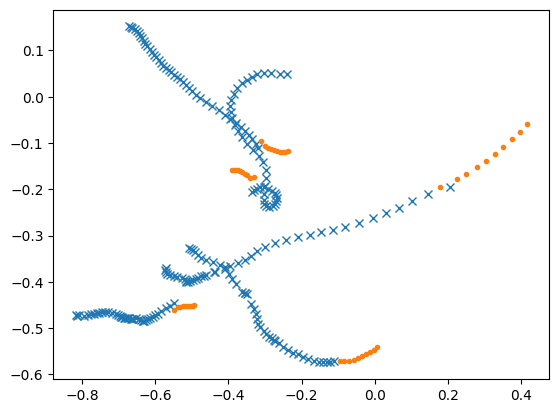

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(test_context.data[:, :, 0], test_context.data[:, :, 1], "x", color="C0")
_ = ax.plot(predicted_context[:, :, 0], predicted_context[:, :, 1], ".", color="C1")

Looks good. To visualize the tropical cyclone tracks and the predictions on the acutal map, we have to scale both back to the original coordinate system.

In [16]:
# #TODO The following generates TensorContextDatasets with smaller context length. This cannot be used as input to prediction for now.
# idx = np.random.randint(0, contexts["train"].shape[0])
# initial_context_arr = contexts['train'].data[:idx,:10]
# print(initial_context_arr.shape)
# print(type(initial_context_arr))
# initial_context = TensorContextDataset(initial_context_arr)
# print(initial_context.shape)
# print(type(initial_context))
# ts = predict_time_series(model, initial_context, n_steps=13)

Predictions are shown as dotted lines. Input test cyclone tracks are shown as solid lines.

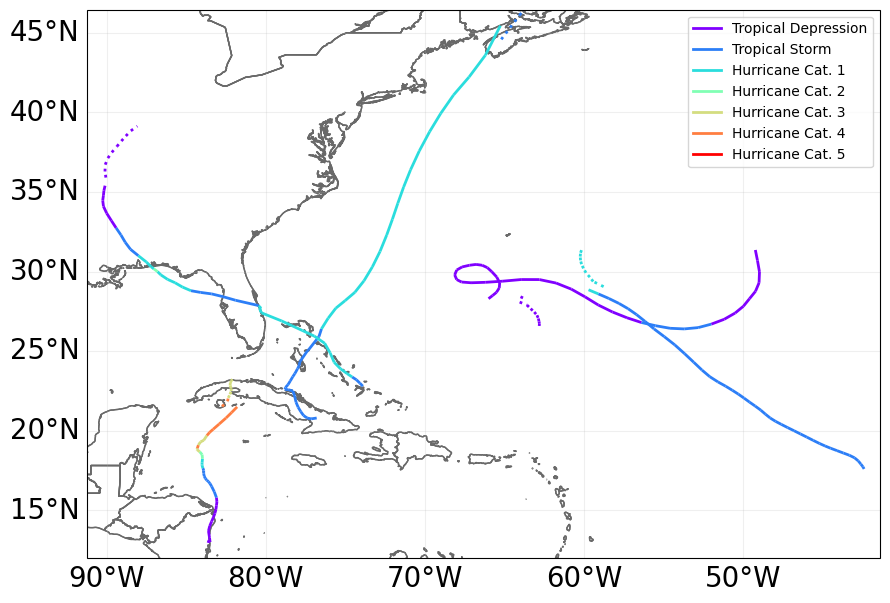

In [17]:
test_context_scaled = scaler.inverse_transform(test_context)
predicted_context_scaled = scaler.inverse_transform(predicted_context)
test_context_tc_tracks = TCTracks_from_TensorContextDataset(test_context_scaled, feature_list=feature_list)
predicted_context_tc_tracks = TCTracks_from_TensorContextDataset(predicted_context_scaled, feature_list=feature_list)

ax = predicted_context_tc_tracks.plot(linestyle="dotted")
_ = test_context_tc_tracks.plot(axis=ax, linestyle="solid")

This looks reasonably. However, the predictions are still improvable. For example we notice an off-set for the predicted trajectory in relation to the context trajectory.

In the next step, we take a closer look at the context length of the training data and study its influence on the model performance.